In [296]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import os

from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

filepath = r'.\figures'
benchmarks = ['Commonsense', 'Math', 'Game', 'Coding', 'Writing']

In [297]:
file = r".\results.xlsx"
df_orig = pd.read_excel(file)

df_single = df_orig[df_orig['num_agent']==1]
df_group = df_orig[df_orig['num_agent']!=1]
print(df_orig.shape, df_single.shape, df_group.shape)

(116, 11) (8, 11) (108, 11)


In [298]:
FONTNAME = "Arial"

# Figure 2(a): cross-task correlation 


In [299]:
df = df_group.copy()
df = df[benchmarks].dropna()

n = df.shape[1]
corr_matrix = df.corr().values
lower_triangle_values = corr_matrix[np.tril_indices(n, k=-1)]
# calculate mean value
mean_value = np.mean(lower_triangle_values)
print(f'Mean correlation: {mean_value:.3f}')

Mean correlation: 0.550


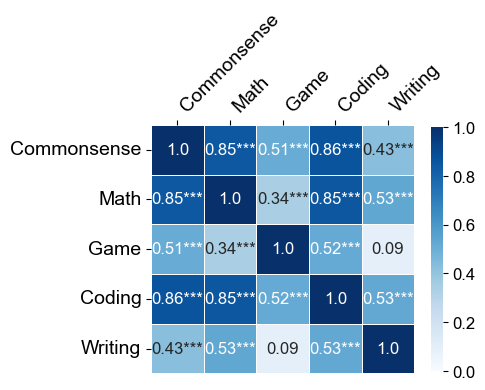

In [300]:
n = df.shape[1]
corr_matrix = df.corr()
p_value_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n): 
        _, p_value_matrix[i, j] = pearsonr(df.iloc[:, i], df.iloc[:, j])
        p_value_matrix[j, i] = p_value_matrix[i, j]  

def significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

annot_matrix = corr_matrix.copy().astype(str)

for i in range(n):
    for j in range(n):
        if i != j:  
            p_val = p_value_matrix[i, j]
            annot_matrix.iloc[i, j] = f"{corr_matrix.iloc[i, j]:.2f}{significance_stars(p_val)}"


plt.figure(figsize=(5, 4))
ax = sns.heatmap(corr_matrix, annot=annot_matrix, cmap='Blues', vmin=0, vmax=1,
            fmt='', linewidths=0.5, cbar_kws={"shrink": 0.98}, 
            annot_kws={"fontname": FONTNAME, "fontsize": 12})

# 设置colorbar字体
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
for label in cbar.ax.get_yticklabels():
    label.set_fontname(FONTNAME)

plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=45, ha='left', fontname=FONTNAME, fontsize=14)
plt.yticks(font=FONTNAME, fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(filepath, 'benchmark_corr.pdf'), format='pdf')

# factor analysis, calculate CI

In [301]:
df = df_group[benchmarks].dropna()

In [302]:
from factor_analyzer import FactorAnalyzer

# Perform factor analysis
fa = FactorAnalyzer(n_factors=5, rotation=None)  # Assume maximum 5 factors
fa.fit(df)

# Get eigenvalues
eigenvalues = fa.get_eigenvalues()

# Calculate variance percentage explained by first factor
total_variance = np.sum(eigenvalues[0]) 
first_factor_variance = eigenvalues[0][0] / total_variance * 100

print(f"Variance percentage explained by first factor: {first_factor_variance:.2f}%")

# Output variance percentage explained by each factor
for i, eigenvalue in enumerate(eigenvalues[0]):
    variance_explained = eigenvalue / total_variance * 100
    print(f"Variance percentage explained by factor {i + 1}: {variance_explained:.2f}%")

Variance percentage explained by first factor: 66.29%
Variance percentage explained by factor 1: 66.29%
Variance percentage explained by factor 2: 18.73%
Variance percentage explained by factor 3: 9.90%
Variance percentage explained by factor 4: 2.62%
Variance percentage explained by factor 5: 2.45%


C:\ProgramData\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [303]:
# confirmatory factor analysis
from semopy import Model
from semopy import calc_stats

model_desc = """
factor1 =~ Commonsense + Math + Game + Coding + Writing
"""

model = Model(model_desc)
model.fit(df)
fit_stats = calc_stats(model)

print(fit_stats)


       DoF  DoF Baseline       chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    5            10  30.638953      0.000011         613.26  0.957499   

            GFI      AGFI       NFI       TLI     RMSEA        AIC        BIC  \
Value  0.950039  0.900078  0.950039  0.914999  0.218914  19.432612  46.253924   

         LogLik  
Value  0.283694  


In [304]:
from factor_analyzer import FactorAnalyzer
from scipy import stats

df = df_group[benchmarks].dropna()

fa = FactorAnalyzer(n_factors=5, rotation=None)  
fa.fit(df)

factor_loadings = fa.loadings_
    
cov_matrix = np.cov(df.T)
se = np.sqrt(np.diag(cov_matrix))

p_values = []
for i, loading in enumerate(factor_loadings):
    t_stat = loading[0] / se[i]
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=len(df)-1)) 
    p_values.append(p_value)

for i, col in enumerate(df.columns):
    print(f"Loading of {col}: {factor_loadings[i][0]:.3f}, p-value: {p_values[i]}")

C:\ProgramData\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Loading of Commonsense: 0.927, p-value: 6.568079413682426e-13
Loading of Math: 0.914, p-value: 1.0772782665924296e-10
Loading of Game: 0.502, p-value: 3.7453834114131723e-06
Loading of Coding: 0.969, p-value: 0.0
Loading of Writing: 0.527, p-value: 1.708766461661071e-11


In [305]:
# calculate CI
df = df_group[benchmarks].dropna()
df = (df - df.mean()) / df.std()

first_factor_loadings = np.array([factor_loadings[i][0] for i in range(len(factor_loadings))])
df['CI'] = df.apply(lambda row: np.sum(row.values * first_factor_loadings), axis=1)
df['CI'] = (df['CI'] - df['CI'].mean()) / df['CI'].std()
df['CI'] = df['CI'] * 15 + 100
cis = df['CI'].tolist()
df.head()

,Commonsense,Math,Game,Coding,Writing,CI
8,-2.826792,-3.263127,-2.772122,-3.273762,0.039519,52.928178
9,-2.121726,-2.480150,1.020076,-1.792825,-2.058822,69.631635
10,-1.064127,-0.992495,-1.702528,-1.324365,-3.015209,73.919710
11,-1.857326,-0.287816,-1.605292,-1.324365,0.239361,81.685036
12,-1.064127,-1.932067,-0.438462,-1.052356,-1.345101,78.186106


# Figure 2(b): leave-one-out test

C:\ProgramData\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.32684056017507485 0.618043193928924 0.48580883675814357
0.8666481253284392 0.9356586196902003 0.90706799337894
0.2770753717789687 0.5830408161202792 0.44286109677887847
0.7830995943042698 0.8928654737328139 0.8467647080749209
0.8160200684388849 0.9099672192941223 0.8707228606942029


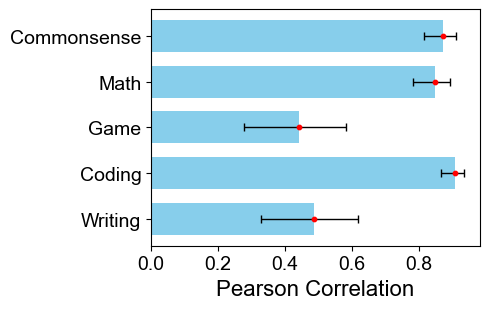

In [306]:
def calculate_ci(selected_benchmarks):
    df = df_group[selected_benchmarks].dropna()

    fa = FactorAnalyzer(n_factors=len(selected_benchmarks), rotation=None)
    fa.fit(df)
    factor_loadings = fa.loadings_
    first_factor_loadings = np.array([factor_loadings[i][0] for i in range(len(factor_loadings))])

    df = (df - df.mean()) / df.std()
    df['CI'] = df.apply(lambda row: np.sum(row.values * first_factor_loadings), axis=1)
    df['CI'] = (df['CI'] - df['CI'].mean()) / df['CI'].std()
    df['CI'] = df['CI'] * 15 + 100
    return df['CI'].tolist()

criteria = []
correlations = []
ci_lower = []
ci_upper = []

for criterion in reversed(benchmarks):
    selected_benchmarks = [x for x in benchmarks if x!=criterion]
    criterion_scores = df_group[criterion].tolist()
    
    ci_scores = calculate_ci(selected_benchmarks)
    pearson = pearsonr(criterion_scores, ci_scores)
    low, high = pearson.confidence_interval(0.95)
    pearson_corr = pearson.statistic
    # print(pearson, low,high)
    criteria.append(criterion)
    correlations.append(pearson_corr)
    ci_lower.append(low)
    ci_upper.append(high)
    print(low, high, pearson_corr)

# plot
plt.figure(figsize=(5, 3.2))
plt.barh(criteria, correlations, xerr=[np.array(correlations) - np.array(ci_lower), 
                                        np.array(ci_upper) - np.array(correlations)],
         capsize=3, color='skyblue', edgecolor=None, height=0.7,
        error_kw={'elinewidth': 1}  # 误差线粗细，默认大概是1
        )
plt.scatter(correlations, range(len(criteria)),
            color='red', zorder=3, s=10)  # s=点的大小

plt.xticks(fontsize=14, fontname=FONTNAME)
plt.yticks(fontsize=14, fontname=FONTNAME)
plt.xlabel('Pearson Correlation', fontsize=16, fontname=FONTNAME)
# plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(filepath, 'leave_one_out_corr.pdf'), format='pdf')

# Figure 3(a): Regression analysis

In [326]:
# calclulate individual intelligence (g) for each LLM
from factor_analyzer import FactorAnalyzer

df = df_single[benchmarks].dropna()

fa = FactorAnalyzer(n_factors=5, rotation=None)
fa.fit(df)

factor_loadings = fa.loadings_

df = df_single[benchmarks].dropna()
df = (df - df.mean()) / df.std()

first_factor_loadings = np.array([factor_loadings[i][0] for i in range(len(factor_loadings))])

df['g'] = df.apply(lambda row: np.sum(row.values * first_factor_loadings), axis=1)
df['g'] = (df['g'] - df['g'].mean()) / df['g'].std()
df['g'] = df['g'] * 15 + 100

llm2g = dict(zip([eval(x)[0] for x in df_single['LLMs'].tolist()], df['g'].tolist()))
llm2g

C:\ProgramData\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


{'glm': 80.52192062822753,
 'gpt35': 86.33492400264294,
 'internlm20b': 92.1270652040478,
 'qwen7b': 94.46241081199491,
 'gemma27b': 95.15572931010226,
 'gpt4omini': 115.19961883226057,
 'qwen32b': 116.28710003351976,
 'qwen72b': 119.91123117720423}

In [327]:
def cal_factors(row):
    llms = eval(row['LLMs'])
    num_llm = len(set(llms))
    adj_matrix = np.array(eval(row['adj_matrix']))
    gs = [llm2g[x] for x in llms]
    avg_g = np.mean(gs)
    max_g = np.max(gs)
    std_g = np.std(gs)
    degrees = np.sum(adj_matrix, axis=0).tolist()
    var_degree = np.var(degrees)
    
    G = nx.from_numpy_array(adj_matrix)
    
    # Number of Edges
    num_edges = G.number_of_edges()

    # Number of Nodes
    num_nodes = G.number_of_nodes()
    num_nodes_square = num_nodes ** 2


    # Centralization
    degree_centralization = nx.degree_centrality(G)
    degree_centralization_score = sum(degree_centralization.values()) / len(degree_centralization)

    closeness_centralization = nx.closeness_centrality(G)
    closeness_centralization_score = sum(closeness_centralization.values()) / len(closeness_centralization)

    betweenness_centralization = nx.betweenness_centrality(G)
    betweenness_centralization_score = sum(betweenness_centralization.values()) / len(betweenness_centralization)

    # Diameter
    diameter = nx.diameter(G)

    # Average Path Length
    avg_path_length = nx.average_shortest_path_length(G)

    # Density
    density = nx.density(G)
    
    effort = num_edges * row['round']
    weighted_g = np.sum([np.sum(degrees[i]*gs[i]) for i in range(num_nodes)])/np.sum(degrees)
    
    deg_g_corr, p = pearsonr(degrees, gs)
    
    return avg_g, max_g, std_g, num_edges, num_nodes, num_nodes_square, var_degree, num_llm, \
        degree_centralization_score, closeness_centralization_score, \
        betweenness_centralization_score, diameter, avg_path_length, density, \
        weighted_g, deg_g_corr, effort

df = df_group.copy()
cols = ['avg_g', 'max_g', 'std_g', 'num_edges', 'num_nodes', 'num_nodes_square', 'var_degree', 'num_llm',
    'degree_centralization_score', 'closeness_centralization_score', 'betweenness_centralization_score', 
    'diameter', 'avg_path_length', 'density', 
    'weighted_g', 'deg_g_corr', 'effort']
df[cols] = df.apply(cal_factors, axis=1, result_type="expand")
df['CI'] = cis

aspect2inds = {
    'Collaboration Process: Skill Congruence':['deg_g_corr'], 
    'Collaboration Process: Variance of Degree':['var_degree'], 
    'Collaboration Process: Effort':['effort'], 
    'Individual Intelligence (Mean)': ['avg_g'],
    'Individual Intelligence (Max)': ['max_g'],
    'Group Size':['num_nodes', 'num_nodes_square',],
              }

X_cols = []
for x in aspect2inds.values():
    X_cols.extend(x)


df = df.dropna(subset=benchmarks+X_cols)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18976\755151820.py:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  deg_g_corr, p = pearsonr(degrees, gs)


In [328]:
import statsmodels.api as sm

X = df[X_cols]
y = df['CI']

X = X.rename(columns={
                'var_degree': 'Process: Variance of Degree', 
                'deg_g_corr':'Process: Skill Congruence',
                'effort':'Process: Effort',
                'avg_g':'Individual Intelligence (Mean)',
                'max_g':'Individual Intelligence (Max)',
                'num_nodes':'Group Size',
                'num_nodes_square':'Group Size (Squared)',
                     })

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


# get coefficients
coefficients = model.params
stderr = model.bse

coefficients_standardized = (coefficients - coefficients.mean()) / coefficients.std()
stderr_standardized = stderr / coefficients.std()

results_df = pd.DataFrame({
    'Coefficient': coefficients_standardized,
    'Std Error': stderr_standardized
})

results_df = results_df.iloc[1:]




                            OLS Regression Results                            
Dep. Variable:                     CI   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     27.82
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           5.74e-16
Time:                        15:34:28   Log-Likelihood:                -193.84
No. Observations:                  70   AIC:                             401.7
Df Residuals:                      63   BIC:                             417.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

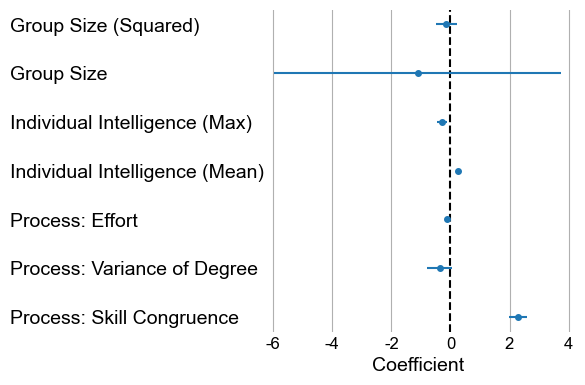

In [310]:
plt.figure(figsize=(6, 4))

for i, (coef, error) in enumerate(zip(results_df['Coefficient'], results_df['Std Error'])):
    plt.errorbar(coef, results_df.index[i], xerr=error, fmt='o', markersize=4, color='C0', capsize=0, zorder=4)

plt.xlabel('Coefficient', fontsize=14, fontname=FONTNAME)
plt.axvline(0, color='black', linestyle='--')  

plt.xticks(fontsize=12, fontname=FONTNAME)
plt.yticks(fontsize=14, fontname=FONTNAME, horizontalalignment='left')
plt.gca().tick_params(axis='y', pad=180)
plt.grid(axis='x')
plt.tight_layout()

ax = plt.gca()
ax.tick_params(axis='both', which='both', length=0)
for spine in ax.spines.values():
    spine.set_visible(False)  # 去掉四条边框线
    
# 去掉x=0的grid
plt.gcf().canvas.draw()
for line in ax.get_xgridlines():
    verts = line.get_path().vertices  # Nx2
    if verts.size == 0:
        continue
    xv = float(verts[0, 0])
    if np.isclose(xv, 0.0):
        line.set_visible(False)

plt.savefig(os.path.join(filepath, 'predict_ci_coefficient.pdf'), format='pdf')

# Figure 3(b): feature importance

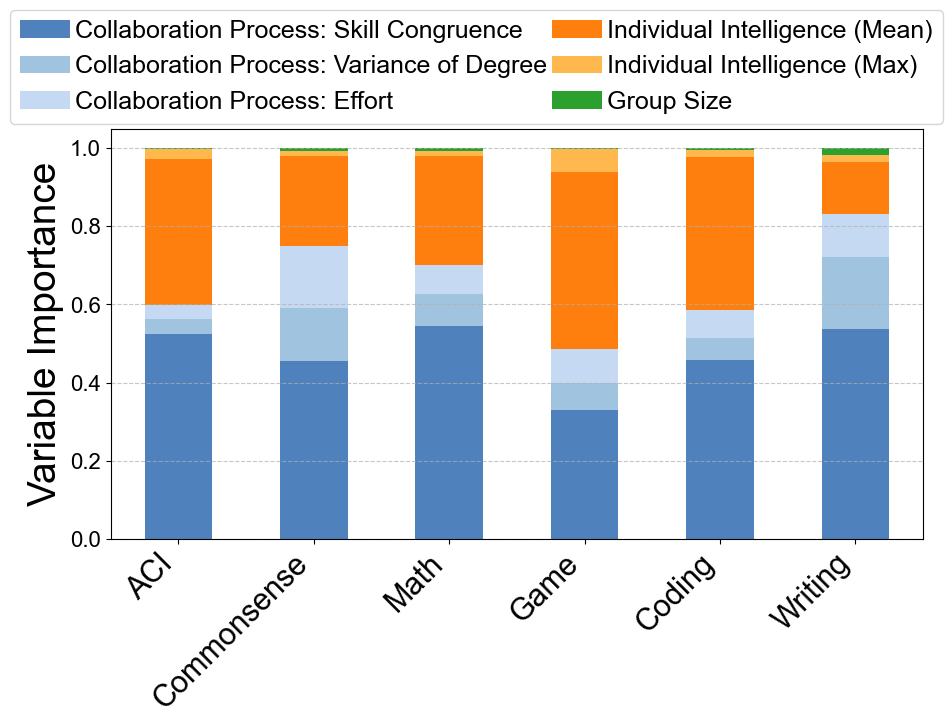

In [316]:
from sklearn.ensemble import RandomForestRegressor


y_targets = ['CI'] + benchmarks

category_importance = {target: {aspect: 0 for aspect in aspect2inds.keys()} for target in y_targets}


for y_target in y_targets:
    X = df[X_cols]
    y = df[y_target]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_model.fit(X, y)

    feature_importance = dict(zip(X.columns, rf_model.feature_importances_))

    # calculate importance for each category
    for aspect, features in aspect2inds.items():
        category_importance[y_target][aspect] = sum(feature_importance.get(f, 0) for f in features)

importance_df = pd.DataFrame(category_importance).T
colors = ['#4F81BD', '#A0C4E0', '#C6D9F2', '#FF7F0E', '#FFB84D', 'C2']
fig, ax = plt.subplots(figsize=(10, 8))
importance_df.plot(kind='bar', stacked=True, ax=ax, color=colors)

ax.set_ylabel("Variable Importance", fontsize=28, fontname=FONTNAME)
ax.set_xlabel("")
xticks = ['ACI'] + importance_df.index[1:].tolist()
ax.set_xticklabels(xticks, rotation=45, ha="right", fontsize=22, fontname=FONTNAME)
plt.yticks(fontsize=16, fontname=FONTNAME)

leg = ax.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.45, 1.32), ncol=2, columnspacing=0.2, handletextpad=0.2)
# 修改legend字体
for text in leg.get_texts():
    text.set_fontname(FONTNAME)
ax.grid(axis='y', linestyle='--', alpha=0.7) 

plt.tight_layout()
plt.savefig(os.path.join(filepath, 'variable_importance.pdf'), format='pdf')


# Figure 5: predicting CI and task performance

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18976\2946548232.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(yticks, fontname=FONTNAME, fontsize=16)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18976\2946548232.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontname=FONTNAME, fontsize=14)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18976\2946548232.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), fontname=FONTNAME, fontsize=14)


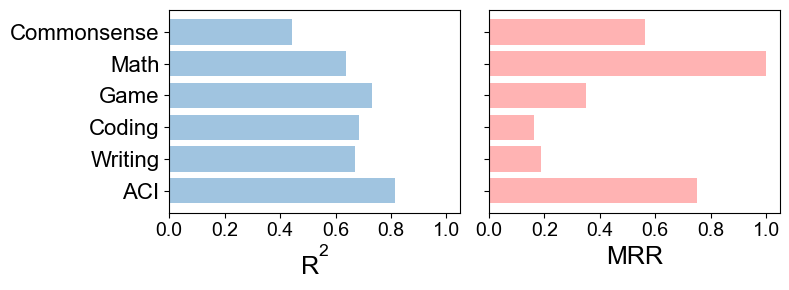

In [321]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

y_targets = ['CI'] + benchmarks[::-1]

r2_scores = []
mrr_scores = []
for y_target in y_targets:

    X = df[X_cols]
    y = df[y_target]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

    cv_r2 = []
    cv_mrr = []

    # cross validation
    for train_idx, test_idx in KFold(n_splits=2).split(X, y): 
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        cv_r2.append(r2)
        
        top5_true = np.argsort(y_test.tolist())[::-1][:5]
        rank = np.argsort(y_pred)[::-1].tolist().index(top5_true[0]) + 1

        mrr = 1 / rank
        cv_mrr.append(mrr)

    mean_r2 = np.mean(cv_r2)
    mean_mrr = np.mean(cv_mrr)
    
    # print(f"Average r2: {mean_r2}")
    # print(f"Average mrr: {mean_mrr}")
    # print("-" * 50)
    

    r2_scores.append(mean_r2)
    mrr_scores.append(mean_mrr)

# print("Final r2 Scores for all targets:", r2_scores)
# print("Final mrr Scores for all targets:", mrr_scores)

# plot
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# subplot 1: R^2 scores
ax[0].barh(y_targets, r2_scores, color='#A0C4E0')
ax[0].set_xlabel('R$^2$', fontsize=18, fontname=FONTNAME)
ax[0].tick_params(axis='y', labelsize=14)
yticks = ['ACI'] + ax[0].get_yticklabels()[1:]
# yticks = ax[0].get_yticklabels()
ax[0].set_yticklabels(yticks, fontname=FONTNAME, fontsize=16)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontname=FONTNAME, fontsize=14)
ax[0].set_xlim([0, 1.05])
# ax[0].grid(axis='x')

# subplot 2: MRR scores
ax[1].barh(y_targets, mrr_scores, color='#FFB3B3')
ax[1].set_xlabel('MRR', fontsize=18, fontname=FONTNAME)
ax[1].tick_params(axis='y', labelsize=0)  # remove y-axis labels of the second subplot
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontname=FONTNAME, fontsize=14)
ax[1].set_xlim([0, 1.05])
# ax[1].grid(axis='x')

plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(filepath, f'rf_prediction_result.pdf'), format='pdf')

# Figure 4: decentralized vs centralized network

In [322]:
import matplotlib as mpl
mpl.rcParams['font.family'] = FONTNAME   

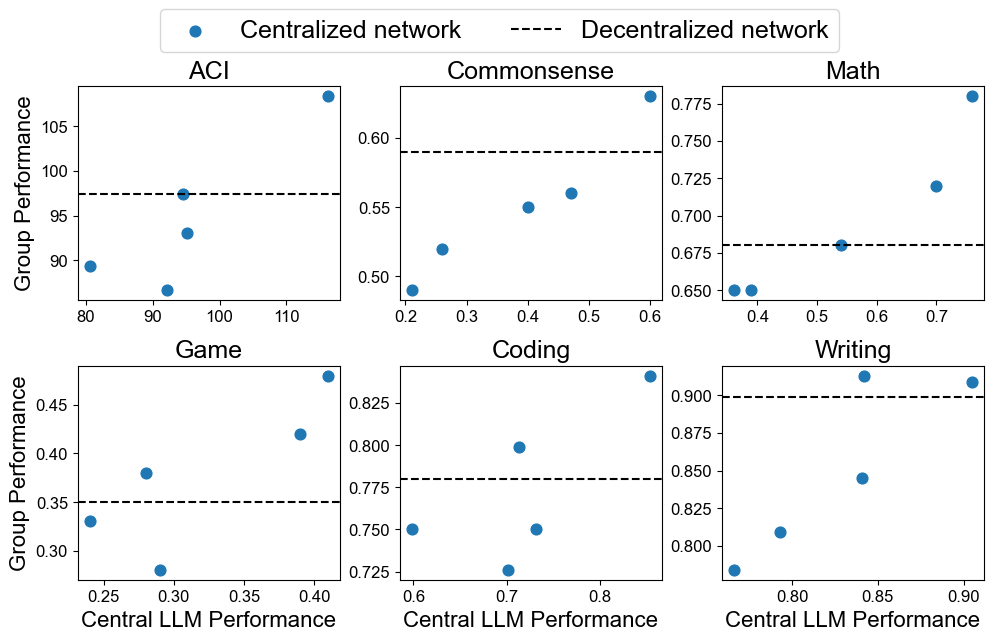

In [323]:
def get_scores(round_num, task, llms):
    if task=='CI':
        llm2score = {}
        for llm in llms:
            llm2score[llm] = llm2g[llm]
    else:
        llm2score = {}
        for llm in llms:
            score = df_single.loc[df_single.apply(lambda x: llm in eval(x['LLMs']), axis=1), task].item()
            llm2score[llm] = score

    best_llm = sorted(llm2score.items(), key=lambda x:x[1], reverse=True)[0][0]
    # print(best_llm)

    homo_llm_score = df.loc[df.apply(lambda x: x['LLMs'].count(best_llm)==5 and x['round']==round_num, axis=1), task].item()
    # print(homo_llm_score)

    complete = df.loc[df.apply(lambda x: set(eval(x['LLMs']))==set(llms) and x['topology']=='complete' and x['round']==round_num, axis=1), task].item()
    # print(complete)

    centralized = []
    for center_llm in llms:
        score = df.loc[df.apply(lambda x: set(eval(x['LLMs']))==set(llms) and x['topology']=='centralize' and eval(x['LLMs'])[0]==center_llm and x['round']==round_num, axis=1), task].item()
        centralized.append(score)
    # print(centralized)
    
    single = list(llm2score.values())
    return single, homo_llm_score, complete, centralized

round_num = 2
tasks = ['CI'] + benchmarks
llms = ['glm', 'internlm20b', 'qwen7b', 'gemma27b', 'qwen32b']

df = df_group.copy()
df['CI'] = cis


fig, axes = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout(pad=5.0)  # Adjust spacing between subplots

# Flatten axes for easier indexing
axes = axes.flatten()

# Loop through each task and corresponding subplot
for idx, task in enumerate(tasks):
    ax = axes[idx]  # Select the corresponding subplot
    single, homo_llm_score, complete, centralized = get_scores(round_num, task, llms)
    
    if task == 'CI':
        ax.scatter(single, centralized, s=60, color='C0', label='Centralized network')
        ax.axhline(y=complete, color='black', linestyle='--', label=f'Decentralized network')
        ax.set_title('ACI', fontsize=18, fontname=FONTNAME)
    else:
        ax.scatter(single, centralized, s=60, color='C0')
        ax.axhline(y=complete, color='black', linestyle='--')
        ax.set_title(task, fontsize=18, fontname=FONTNAME)

    if idx%3==0:
        ax.set_ylabel('Group Performance', fontsize=16, fontname=FONTNAME)
    if idx >= 3:
        ax.set_xlabel('Central LLM Performance', fontsize=16, fontname=FONTNAME)
        
        
    ax.tick_params(axis='both', labelsize=12, labelcolor='black')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname(FONTNAME)
        
    
    # ax.grid(True)

    

font_prop = fm.FontProperties(family=FONTNAME, size=18) 
fig.legend(loc='upper center', ncol=2, prop=font_prop, bbox_to_anchor=(0.5, 1.08))
plt.tight_layout()
plt.savefig(os.path.join(filepath, f'centralize_comlete_comparsion.pdf'), format='pdf', bbox_inches="tight")
plt.show()